In [0]:
# General Libs
from tensorflow import keras
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import *
from tensorflow.keras.initializers import *
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.models import Sequential
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from glob import glob


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
im_shape = (224,224)
TRAINING_DIR = '/content/drive/My Drive/chest-xray-pneumonia/chest_xray/train'
VAL_DIR = '/content/drive/My Drive/chest-xray-pneumonia/chest_xray/val'
TEST_DIR = '/content/drive/My Drive/chest-xray-pneumonia/chest_xray/test'

seed = random.randint(1, 1000)

BATCH_SIZE = 8
num_classes = 2

learning_rate = 0.0001

In [6]:
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input) #rescale=1./255,

train_generator = data_generator.flow_from_directory(TRAINING_DIR, target_size=(im_shape[0],im_shape[1]), shuffle=True, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="training")#, color_mode='grayscale')

val_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
validation_generator = val_generator.flow_from_directory(VAL_DIR, target_size=(im_shape[0],im_shape[1]), shuffle=False, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE)#, color_mode='grayscale')
nb_train_samples = train_generator.samples
nb_validation_samples = validation_generator.samples

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [7]:
from keras.preprocessing.image import ImageDataGenerator

test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)#rescale=1./255

test_generator = test_generator.flow_from_directory(TEST_DIR, target_size=(im_shape[0],im_shape[1]), shuffle=False, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="training")#, color_mode='grayscale')
nb_test_samples = test_generator.samples

Using TensorFlow backend.


Found 624 images belonging to 2 classes.


/content/drive/My Drive/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0367-0001.jpeg
/content/drive/My Drive/chest-xray-pneumonia/chest_xray/test/NORMAL/IM-0027-0001.jpeg


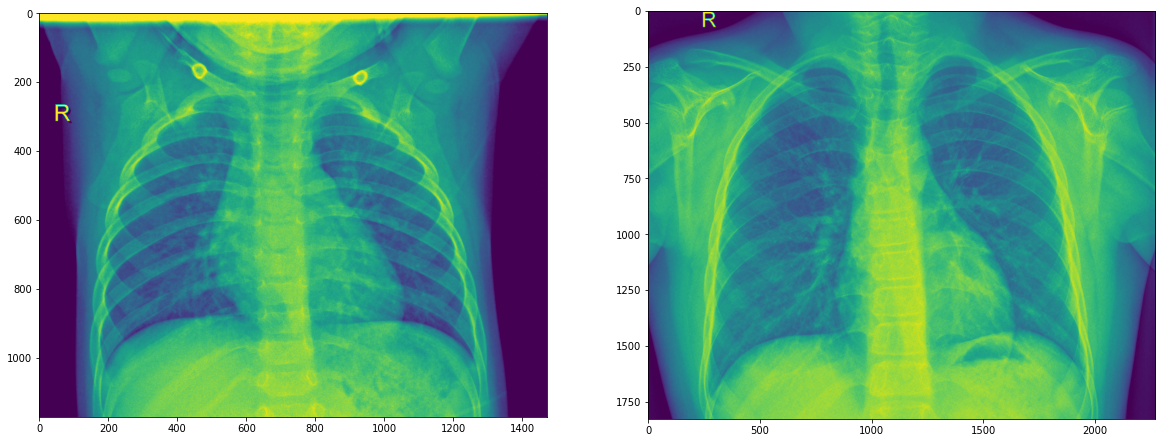

In [8]:
# Looking for some examples

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
img = train_generator.filepaths[np.random.randint(low=0, high=train_generator.samples)]
print(img)
img = mpimg.imread(img)
plt.imshow(img);

plt.subplot(1, 2, 2)
img = test_generator.filepaths[np.random.randint(low=0, high=test_generator.samples)]
print(img)
img = mpimg.imread(img)
plt.imshow(img);

In [9]:

# Loading MobileNet without top layer
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(im_shape[0], im_shape[1], 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(rate = .4)(x)
x = BatchNormalization()(x)
x = Dense(1280, activation='relu',  kernel_initializer=glorot_uniform(seed))(x)
x = Dropout(rate = .4)(x)
x = BatchNormalization()(x)
predictions = Dense(num_classes, activation='softmax', kernel_initializer='random_uniform')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freezing MobileNet layers
for layer in base_model.layers:
    layer.trainable=False
    
optimizer = Adam(lr=learning_rate)

model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

9412608/9406464 [==============================] - 1s 0us/step


In [10]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(
           'balanced',
            np.unique(train_generator.classes), 
            train_generator.classes)
class_weights

array([1.9448173 , 0.67303226])

In [11]:
epochs = 10

#Save the best model acoording to validation loss
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='model.h5',
        monitor='val_loss', save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=50,verbose=1)
]

history = model.fit(
        train_generator,
        steps_per_epoch=nb_train_samples // BATCH_SIZE,
        epochs=epochs,
        callbacks = callbacks_list,
        validation_data=validation_generator,
        verbose = 1,
        validation_steps=nb_validation_samples // BATCH_SIZE,
        )


Epoch 1/10
652/652 [==============================] - ETA: 0s - loss: 0.2914 - accuracy: 0.8963
Epoch 00001: val_loss improved from inf to 0.17023, saving model to model.h5
652/652 [==============================] - 2525s 4s/step - loss: 0.2914 - accuracy: 0.8963 - val_loss: 0.1702 - val_accuracy: 0.8750
Epoch 2/10
652/652 [==============================] - ETA: 0s - loss: 0.1901 - accuracy: 0.9260
Epoch 00002: val_loss did not improve from 0.17023
652/652 [==============================] - 234s 359ms/step - loss: 0.1901 - accuracy: 0.9260 - val_loss: 0.2514 - val_accuracy: 0.8750
Epoch 3/10
652/652 [==============================] - ETA: 0s - loss: 0.1726 - accuracy: 0.9373
Epoch 00003: val_loss did not improve from 0.17023
652/652 [==============================] - 236s 362ms/step - loss: 0.1726 - accuracy: 0.9373 - val_loss: 0.2818 - val_accuracy: 0.8750
Epoch 4/10
652/652 [==============================] - ETA: 0s - loss: 0.1959 - accuracy: 0.9252
Epoch 00004: val_loss improved fro

In [12]:
score = model.evaluate(test_generator,verbose=1)
print("The accuracy is",score[1]*100)

78/78 [==============================] - 285s 4s/step - loss: 0.7670 - accuracy: 0.8045
The accuracy is 80.44871687889099


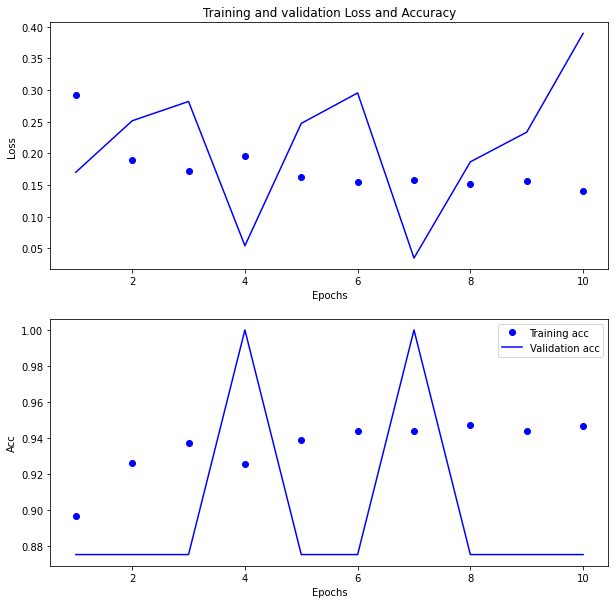

In [15]:
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs_x = range(1, len(loss_values) + 1)
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(epochs_x, loss_values, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.legend()
plt.subplot(2,1,2)
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs_x, acc_values, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc_values, 'b', label='Validation acc')
#plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()


In [0]:
from tensorflow.keras.models import load_model
# Load the best saved model
model = load_model('model.h5')

In [17]:
# Some reports
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

#Confution Matrix and Classification Report
Y_pred = model.predict_generator(test_generator, nb_test_samples // BATCH_SIZE+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))
print('Classification Report')
target_names = ['Normal', 'Pneumo']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

Instructions for updating:
Please use Model.predict, which supports generators.
Confusion Matrix
[[174  60]
 [ 12 378]]
Classification Report
              precision    recall  f1-score   support

      Normal       0.94      0.74      0.83       234
      Pneumo       0.86      0.97      0.91       390

    accuracy                           0.88       624
   macro avg       0.90      0.86      0.87       624
weighted avg       0.89      0.88      0.88       624



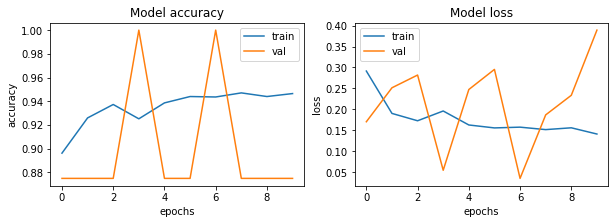

In [19]:
# Visualize Loss and Accuracy Rates
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])